# Machine Learing Skills Gathering
> Grab list of most popular keywords on Indeed.com for Machine Learning Engineer positions on Indeed.com

- toc: true 
- badges: true
- comments: true
- categories: [jupyter, beautifulSoup]

When looking for a new job, in a new field, its hard to know exactly what skills a company is looking for. So I wanted to know what are the most freaquently used keywords for Machine Learning Engineer job descriptions. 

One way to do this, would be go though every job description and find the skills that are listed, then write them down.

However, being a software engineer, I decided to automate the process. 
So for this project, I decided to use web scraping to find the latest job descriptions and pull the keywords

# Overview

For this project, I first needed to find a way to get the latest job posting by title and location. I've been using BeautifulSoup for awhile and knew that if I could load a job description, I could then use BeautifuSoup to read that job description. 

In [ ]:
pip install wordcloud

In [175]:
from bs4 import BeautifulSoup 
import requests
import re 
from collections import Counter 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
nlp = spacy.load("en_core_web_sm")

import pandas as pd
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Return the unique words in the job descirpotion. 

The `get_data` function in the code cell above loads the webpage containing a job description. I then find the actual job description text by grabbing the `jobsearch-jobDescriptionText` id in the webpage.

To grab the most import words in the job description, i'm using NER(Named Entity Reconition) in  Spacy to return only phrases that contain a Noun
. This returns a much better list of keywords instead of just returning all the words. 


In [193]:
def get_data(website):
  print("loading job data from",website)
  site = requests.get(website).content

  soup = BeautifulSoup(site)
  job = soup.find("div", {"class": "jobsearch-jobDescriptionText"})

  text = []
  for p in job.find_all("li"):
    text.append(p.text)

  text = " ".join(text)
  return text

def get_keywords(text):
  result = []

  pos_tag = ['NOUN']
  doc = nlp(text.lower())

  for chunk in doc.noun_chunks:
      final_chunk = ""
      for token in chunk:
          if (token.pos_ in pos_tag):
              final_chunk =  final_chunk + token.text + " "
      if final_chunk:
          result.append(final_chunk.strip())


  for token in doc:
      if (token.text in nlp.Defaults.stop_words or token.text in punctuation):
          continue
      if (token.pos_ in pos_tag):
          result.append(token.text)

  results = list(set(result))
  return [word for word in results if len(word) > 5]

Next, let's grab a random job description to see the first 20 keywords

In [196]:
text = get_data("https://www.indeed.com/viewjob?jk=14d6693d03cd1d67&from=serp&vjs=3")
get_keywords(text)[:20]

loading job data from https://www.indeed.com/viewjob?jk=14d6693d03cd1d67&from=serp&vjs=3


['modeling',
 'product metrics',
 'benchmark',
 'product needs',
 'engineers',
 'quality',
 'reviews',
 'product understanding',
 'recommendation problems',
 'data structures',
 'code reviews',
 'production quality solutions',
 'intuition',
 'performance',
 'problems',
 'benchmark metrics',
 'options',
 'engineering',
 'multitude',
 'pattern']

Here, I grab a Machine Learning Engineer position for Twitter and return a list of keywords. This just finds the job description, saves the text as a list of words and removes words that are not revelated(`and`, `the` etc). These words are also know as stopwords.

In [251]:
def get_job_page(city, state, job):
  final_city = city.split()
  final_city = '+'.join(word for word in final_city)
  final_site_list = ['http://www.indeed.com/jobs?q=', job, '&l=', final_city,
  '%2C+', state] 


  final_site = ''.join(final_site_list) 
  final_site

  html = requests.get(final_site).content
  soup = BeautifulSoup(html) 

  num_jobs_area = soup.find("div",{"id":'searchCountPages'}).text
  num_jobs_area
  job_numbers = re.findall("\d+",num_jobs_area)
  current_page, total_num_pages = int(job_numbers[0]), int(job_numbers[1])
  return final_site, current_page, total_num_pages

final_site, current_page, total_num_pages = get_job_page("New York", "NY", "'machine-learning-engineer'")

In the cell above, I first need to get the first page of results. The format of the url needs to be:
```
'http://www.indeed.com/jobs?q=', job, '&l=', final_city, '%2C+', state, %start=0
```

So for Machine Learning Engineer positions located in New York, NY, the URL will look like this:
```
https://www.indeed.com/jobs?q=machine-learning-engineer&l=New+York,+NY&start=0
```
After I get the first page, I then need to grab the total number of pages. This is located in the `searchCountPages` div.
Next, I pull out the 2 numbers in that div, which looks like 
```
Page x of y
```
I used a simple regex to pull the 2 numbers from this div and used this as the start page(`x`) and total number of pages(`y`)
This is saved in `current_page` and `total_num_pages`.


In the next cell, I then loop thought the number of pages and append the `start` index to url as the index of the current page. 

I first calcuate the number of pages by 
```Python
num_pages = round(total_num_pages/15)
```
This takes the total number and divides by 15. This is because I dont know *exactly* how many results are returned for each page, and after some testing, 15 is about the average. 

At the time of this post, there are about 47 jobs posted. And therefore, I need to load 3 pages of results..

Next, I used BeautifuSoup to load of the content of each page and find the job url, which is used to fetch the job description. 
The url to the job contains the path `clk`. Therefore, I needed to filter the url's returned from the page to only contain urls that have the `clk` path. The results returned from the `filter` function are the job description urls. 

Finally, for each URL, I then get the job description words using the `get_data()` function from ealier


In [252]:

def get_jobs(final_site, current_page, total_num_pages):
  doc_frequency = Counter()

  num_pages = round(total_num_pages/15)
  print("Number of Pages",num_pages)
  for i in range(num_pages): 
    print('Getting page', i)
    start_num = str(i*10)
    current_page = ''.join([final_site, '&start=', start_num])
    print("total pages",current_page)
    page = requests.get(current_page).content
    soup = BeautifulSoup(page) 
    job_link_area = soup.find(id = 'resultsCol')
    job_URLS = ["http://www.indeed.com" + a['href'] for a in job_link_area.find_all('a', href=True)]
    job_URLS = filter(lambda x:'clk' in x, job_URLS)

    for url in job_URLS:
      job_desc_text = get_data(url)
      keywords = get_keywords(job_desc_text)
      job_descriptions.append(keywords)
      [doc_frequency.update(item) for item in job_descriptions]

    return doc_frequency

doc_frequency = get_jobs(final_site, current_page, total_num_pages)

Number of Pages 3
Getting page 0
total pages http://www.indeed.com/jobs?q='machine-learning-engineer'&l=New+York%2C+NY&start=0
loading job data from http://www.indeed.com/rc/clk?jk=14d6693d03cd1d67&fccid=7a3824693ee1074b&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=7dab88fcf921f518&fccid=e2a37b55a93b50b2&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=2596a581cc5517bf&fccid=2689b06a1fbc0bc4&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=c4d2b45f58a26a83&fccid=5bd99dfa21c8a490&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=6436e44787661e89&fccid=1b3df0faac85255e&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=1a9c4e5ad5cb4393&fccid=ce3b6f8ba0332e43&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=c17bcc51c3d895e8&fccid=16a97ed26c75bf2d&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=4cae4a1a1a7b3381&fccid=a2bc1e38165c6c18&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=eb7a384f353a5b2b&fc

So for each job, I append the words to a `doc_frequency` Counter, which just counts the total number of words contained in every job description.

To Close this out, lets plot these keywords into a WordCloud for better visibility

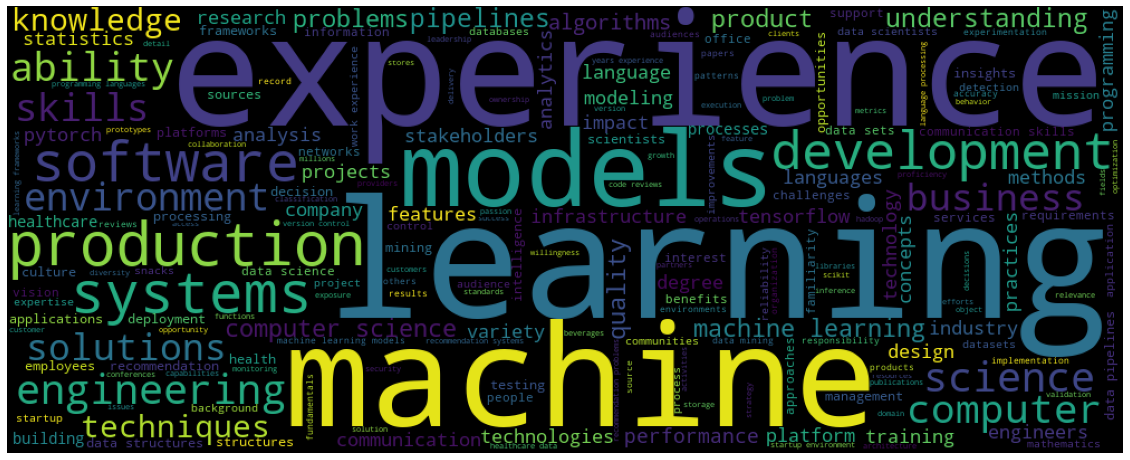

In [249]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt 

wordcloud = WordCloud(width=1000, height=400)
wordcloud.generate_from_frequencies(frequencies=doc_frequency)
plt.figure(figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

For reference, lets also plot the top 100 words:

In [242]:
doc_frequency.most_common()[:100]

[('experience', 722),
 ('learning', 705),
 ('machine', 677),
 ('models', 559),
 ('production', 553),
 ('systems', 479),
 ('software', 470),
 ('environment', 430),
 ('development', 430),
 ('engineering', 429),
 ('ability', 415),
 ('science', 408),
 ('computer', 388),
 ('skills', 380),
 ('business', 376),
 ('techniques', 365),
 ('solutions', 349),
 ('machine learning', 338),
 ('understanding', 327),
 ('pipelines', 326),
 ('problems', 297),
 ('computer science', 290),
 ('performance', 283),
 ('product', 278),
 ('analysis', 277),
 ('algorithms', 275),
 ('knowledge', 272),
 ('quality', 270),
 ('engineers', 266),
 ('infrastructure', 237),
 ('features', 237),
 ('training', 231),
 ('languages', 226),
 ('opportunities', 222),
 ('communication', 222),
 ('degree', 217),
 ('technologies', 212),
 ('design', 211),
 ('variety', 208),
 ('stakeholders', 202),
 ('recommendation', 201),
 ('programming', 196),
 ('impact', 192),
 ('tensorflow', 189),
 ('technology', 184),
 ('projects', 184),
 ('industry', 

# Other Postions

For funzies, lets see what other skills are most present in other roles, day Data Scientist

Number of Pages 43
Getting page 0
total pages http://www.indeed.com/jobs?q=data+scientist&l=New+York%2C+NY&start=0
loading job data from http://www.indeed.com/rc/clk?jk=b6e4fc84c7d476ea&fccid=1b50fcfb150b1b48&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=62d25207253030d0&fccid=049a66f3ffa9366a&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=3483ac001da233ed&fccid=e571ceda55e25d27&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=549b343d185ed525&fccid=30cb52ad6dd37131&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=00b8c73d3919724e&fccid=30cb52ad6dd37131&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=65702776ee7f6924&fccid=be3b11aa573faee7&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=b80c4e9ec85f3c6d&fccid=978d9fd9799d55a8&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=148f2e5e7a652368&fccid=2721c1c2ba33c638&vjs=3
loading job data from http://www.indeed.com/rc/clk?jk=de01cecba45a129c&fccid=b374f2a7

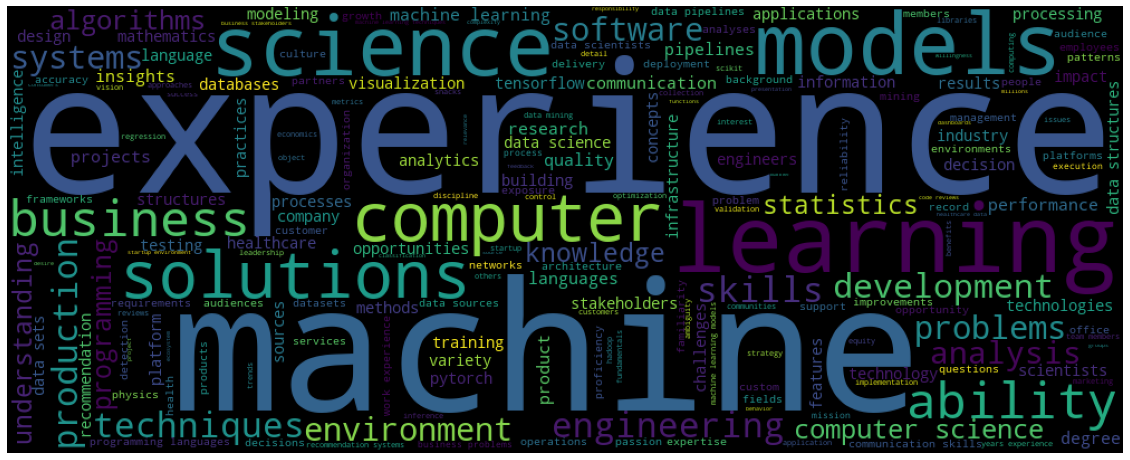

In [260]:
final_site, current_page, total_num_pages = get_job_page("New York", "NY", "data+scientist")
doc_frequency = get_jobs(final_site, current_page, total_num_pages)
wordcloud = WordCloud(width=1000, height=400)
wordcloud.generate_from_frequencies(frequencies=doc_frequency)
plt.figure(figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Conclusion

So far, we have a nice application that shows the most frequent keywords in Machine Learning Engineer and Data Scientist postions. 

I think there are more things that can be done with this, especially, using Named Enity Reconition for returning the keywords. 
One though is to see if Google's BERT pretrained model would be better at extracting skills. We could also try to simpliy and give a list of keywords("python", "pytorch" .. etc) and see how many times those skills are listened.